# Diamond - Ordinal Logistic Regression
The cumulative logistic model with proportional odds is
$$Pr(y_i \leq j) = \sigma^{-1}(\alpha_j + \vec\beta \cdot \vec x)$$
where $\sigma(x) = log \frac{x}{1-x}$ is the logit function and $\sigma^{-1}(x) = \frac{1}{1+e^{-x}}$ is its inverse

The likelihood of this model is
$$l(\textbf{x, y}| \vec \alpha, \vec \beta ) = \sum\limits_{i=1}^n \sum\limits_{j=1}^J y_{ij} \left [ \sigma^{-1}(\alpha_j + \vec \beta \cdot \vec x_i) - \sigma^{-1}(\alpha_{j-1} + \vec \beta \cdot \vec x_i) \right ]$$

**Diamond** fits an $L_2$-regularized version of this model with a Fixed Hessian Newton method.
* See Agresti, Categorical Data Analysis, 2nd Ed., Chapter 7 for a complete description of the proportional odds cumulative logistic model
* The Fixed Hessian Newton method is adapted from [Thomas Minka](https://tminka.github.io/papers/logreg/minka-logreg.pdf). It requires the gradient and a single evaluation of the hessian
* These derivatives are as follows. Here is a [citation](http://www.biomedcentral.com/content/supplementary/s12911-015-0133-y-s1.pdf), but it has a couple of types so beware

### Gradient
$$ \frac{\partial l}{\partial \alpha_1} = \sum\limits_{i=1}^n \left [ 1(y_{ij} = 1)\left (1 - \sigma^{-1}(\alpha_1 + \vec \beta \cdot \vec x_i) \right ) - 1(y_{ij} = 2)\left (\frac{e^{\alpha_1}}{e^{\alpha_2} - e^{\alpha_1}} + \sigma^{-1}(\alpha_1 + \vec \beta \cdot \vec x_i) \right ) \right ]$$

for $2 \leq j \leq J-2$, the gradient is
$$\frac{\partial l}{\partial \alpha_j} = \sum\limits_{i=1}^n \left [ 1(y_{ij} = j)\left (\frac{e^{\alpha_j}}{e^{\alpha_j} - e^{\alpha_{j-1}}} - \sigma^{-1}(\alpha_j + \vec \beta \cdot \vec x_i) \right ) - 1(y_{ij} = j+1)\left (\frac{e^{\alpha_j}}{e^{\alpha_{j+1}} - e^{\alpha_j}} + \sigma^{-1}(\alpha_j + \vec \beta \cdot \vec x_i) \right ) \right ]$$

For the last intercept,
$$\frac{\partial l}{\partial \alpha_{J-1}} = \sum\limits_{i=1}^n \left [ 1(y_{ij} = J-1)\left (\frac{e^{\alpha_{J-1}}}{e^{\alpha_{J-1}} - e^{\alpha_{J-2}}} - \sigma^{-1}(\alpha_{J-1} + \vec \beta \cdot \vec x_i) \right ) - 1(y_{ij} = J)\left (\sigma^{-1}(\alpha_{J-1} + \vec \beta \cdot \vec x_i) \right ) \right ]$$

Lastly,
$$\frac{\partial l}{\partial \beta} = \sum\limits_{i=1}^n \left [ 1(y_{ij} = 1)\left [ \left ( 1 - \sigma^{-1}(\alpha_1 + \vec \beta \cdot \vec x_i) \right ) \vec x_i \right ]+ \sum\limits_{j=2}^{J-1} \left [ \left ( 1 - \sigma^{-1}(\alpha_j + \vec\beta \cdot \vec x_i) - \sigma^{-1}(\alpha_{j-1} + \vec\beta \cdot \vec x_i) \right ) \vec x_i \right ] + 1(y_{ij} = J)\left [ \left (-\sigma^{-1}(\alpha_{J-1} + \vec\beta \cdot \vec x_i) \right ) \vec x_i \right ] \right ]$$

### Hessian.
$$ \frac{\partial^2 l}{\partial \alpha_1^2} = \sum\limits_{i=1}^n \left [ 
1(y_{ij} = 1)\left ( 
  \frac{e^{\alpha_1 + \vec\beta\cdot\vec x_i}}{(1 + e^{\alpha_1 + \vec\beta\cdot\vec x_i})^2} \right )  -  1(y_{ij} = 2)\left ( 
  \frac{e^{\alpha_1 + \alpha_2}}{(e^{\alpha_2} - e^{\alpha_1})^2} + \frac{e^{\alpha_1 + \vec\beta\cdot\vec x_i}}{(1 + e^{\alpha_1 + \vec\beta\cdot\vec x_i})^2} 
  \right ) 
\right ]$$

for $2 \leq j \leq J-2$, the Hessian is
$$ \frac{\partial^2 l}{\partial \alpha_j^2} = 
\sum\limits_{i=1}^n \left [ 
  -1(y_{ij} = j) \left ( 
        \frac{e^{\alpha_{j-1} + \alpha_j}}{(e^{\alpha_j} - e^{\alpha_{j-1}})^2} + 
        \frac{e^{\alpha_j + \vec\beta\cdot\vec x_i}}{(1 + e^{\alpha_j + \vec\beta\cdot\vec x_i})^2} 
  \right ) - 1(y_{ij} = j+1) \left ( 
      \frac{e^{\alpha_{j} + \alpha_{j+1}}}{(e^{\alpha_{j+1}} - e^{\alpha_{j}})^2} + 
      \frac{e^{\alpha_j + \vec\beta\cdot\vec x_i}}{(1 + e^{\alpha_j + \vec\beta\cdot\vec x_i})^2}   
  \right )
\right ]$$

For the last intercept,
$$ \frac{\partial^2 l}{\partial \alpha_{J-1}^2} = 
\sum\limits_{i=1}^n \left [ 
  -1(y_{ij} = J-1) \left ( 
        \frac{e^{\alpha_{J-2} + \alpha_{J-1}}}{(e^{\alpha_{J-1}} - e^{\alpha_{J-2}})^2} + 
        \frac{e^{\alpha_{J-1} + \vec\beta\cdot\vec x_i}}{(1 + e^{\alpha_{J-1} + \vec\beta\cdot\vec x_i})^2} 
  \right ) - 1(y_{ij} = J) \left ( 
      \frac{e^{\alpha_{J-1} + \vec\beta\cdot\vec x_i}}{(1 + e^{\alpha_{J-1} + \vec\beta\cdot\vec x_i})^2}   
  \right )
\right ]$$

For adjacent intercepts, $1 \leq j \leq J-2$,
$$ \frac{\partial^2 l}{\partial \alpha_j \partial \alpha_{j+1}} = 
\sum\limits_{i=1}^n \left [ 
    1(y_{ij} = j+1) \left (
        \frac{e^{\alpha_j + \alpha_{j+1}}}{(e^{\alpha_{j+1}} - e^{\alpha_j})^2}
    \right )
\right ]$$

Non-adjacent intercepts have zero mixed partials, i.e. for $1 \leq j \leq J-3$
$$ \frac{\partial^2 l}{\partial \alpha_j \partial \alpha_{j+2}} = 0$$

Penultimately, the intercept-slope mixed partial is
$$ \frac{\partial^2 l}{\partial \alpha_j \partial \beta} = 
\sum\limits_{i=1}^n \left [ 
    \left (
        1(y_{ij} = j) + 1(y_{ij} = j+1)
    \right ) 
    \left (
        -\frac{e^{\alpha_j + \vec\beta\cdot\vec x_i}}{(1+e^{\alpha_j + \vec\beta\cdot\vec x_i})^2}
    \right ) \vec x_i
\right ]$$

And finally, 
$$ \frac{\partial^2 l}{\partial \beta^2} = X^TDX$$ where D is a n-by-n diagonal matrix whose i-th entry is 
$$D_{ii} = 
-1(y_i = 1) \left [
    \frac{e^{\alpha_1 + \vec\beta\cdot\vec x_i}}{(1+e^{\alpha_1 + \vec\beta\cdot\vec x_i})^2}
\right ]
- \sum\limits_{j=2}^{J-1} 1(y_i = j) \left [
\frac{e^{\alpha_j + \vec\beta\cdot\vec x_i}}{(1+e^{\alpha_j + \vec\beta\cdot\vec x_i})^2} +
\frac{e^{\alpha_{j-1} + \vec\beta\cdot\vec x_i}}{(1+e^{\alpha_{j-1} + \vec\beta\cdot\vec x_i})^2}
\right ]
- 1(y_i = J) \left [
    \frac{e^{\alpha_{J-1} + \vec\beta\cdot\vec x_i}}{(1+e^{\alpha_{J-1} + \vec\beta\cdot\vec x_i})^2}
\right ]$$

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from diamond.glms.cumulative_logistic import CumulativeLogisticRegression
 # gradient function is just to illustrate convergence
from diamond.solvers.utils import l2_clogistic_gradient 
import logging
import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig()


In [2]:
wine = pd.read_csv("wine.csv")
wine.head()

,response,rating,temp,contact,bottle,judge
0,36,2,cold,no,1,1
1,48,3,cold,no,2,1
2,47,3,cold,yes,3,1
3,67,4,cold,yes,4,1
4,77,4,warm,no,5,1


In [3]:
# convert categorical to numeric
wine.temp = 1.0 * (wine.temp == 'warm')
wine.contact = 1.0 * (wine.contact == "yes")

In [4]:
clmm_variance =  1.2798  # estimated in R's ordinal package
df_variance = pd.DataFrame({"group": "judge", "var1":"intercept", "vcov":clmm_variance, 
                            "var2":np.nan, "sdcor":np.sqrt(clmm_variance)}, index=[0])
df_variance

,group,sdcor,var1,var2,vcov
0,judge,1.131282,intercept,NaN,1.2798


# Fixed Hessian Newton Method

In [5]:
ff = "rating ~ temp + contact + (1 | judge)"
solver = CumulativeLogisticRegression(wine, df_variance)
results = solver.fit(ff, tol=1e-8, verbose=True)

INFO:diamond.glms.glm:creating main design matrix
INFO:diamond.glms.glm:creating judge design matrix
INFO:diamond.glms.cumulative_logistic:Creating response matrix.
INFO:diamond.glms.cumulative_logistic:Created response matrix with shape (72, 5)
INFO:diamond.glms.glm:creating covariance matrix
INFO:diamond.glms.cumulative_logistic:creating Hessians
INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit fixed effects
INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit judge
/Users/tsweetser/.virtualenvs/stitch/lib/python2.7/site-packages/diamond/solvers/diamond_cumulative_logistic.py:75: RuntimeWarning: invalid value encountered in double_scalars
  np.linalg.norm(effects[grouping])
INFO:diamond.solvers.diamond_cumulative_logistic:change = 1.000000
INFO:diamond.solvers.diamond_cumulative_logistic:seconds elapsed: 0
INFO:diamond.solvers.diamond_cumulative_logistic:iteration: 0 relative coef change: 1.000000
INFO:diamond.solvers.diamond_cumulative_logistic:Starting t

INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit judge
INFO:diamond.solvers.diamond_cumulative_logistic:change = 0.000007
INFO:diamond.solvers.diamond_cumulative_logistic:seconds elapsed: 0
INFO:diamond.solvers.diamond_cumulative_logistic:iteration: 20 relative coef change: 0.000007
INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit fixed effects
INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit judge
INFO:diamond.solvers.diamond_cumulative_logistic:change = 0.000005
INFO:diamond.solvers.diamond_cumulative_logistic:seconds elapsed: 0
INFO:diamond.solvers.diamond_cumulative_logistic:iteration: 21 relative coef change: 0.000005
INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit fixed effects
INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit judge
INFO:diamond.solvers.diamond_cumulative_logistic:change = 0.000004
INFO:diamond.solvers.diamond_cumulative_logistic:seconds elapsed: 0
INFO:diamond.solvers.diamond_cumulat

INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit fixed effects
INFO:diamond.solvers.diamond_cumulative_logistic:Starting to fit judge
INFO:diamond.solvers.diamond_cumulative_logistic:change = 0.000000
INFO:diamond.solvers.diamond_cumulative_logistic:seconds elapsed: 1
INFO:diamond.solvers.diamond_cumulative_logistic:iteration: 42 relative coef change: 0.000000
INFO:diamond.solvers.diamond_cumulative_logistic:total seconds elapsed: 1
INFO:diamond.solvers.diamond_cumulative_logistic:reached convergence after 42 steps. relative coef change: 0.000000
INFO:diamond.glms.cumulative_logistic:extracting coefficients


In [6]:
intercept_R = pd.read_csv("intercept_R.txt", header=None)[0]
fixef_R = pd.read_csv("fixef_R.txt", header=None)[0]
ranef_R = pd.read_csv("ranef_R.txt", header=None)[0]

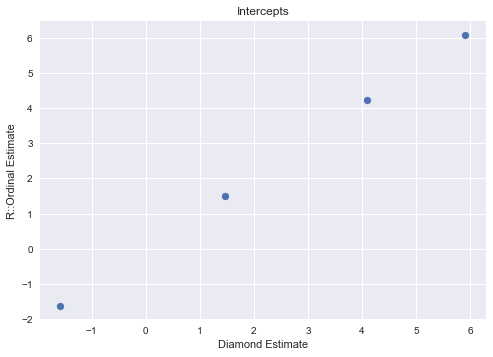

rel difference of 0.029781


In [7]:
plt.scatter(results['intercepts'], intercept_R)
plt.xlabel("Diamond Estimate")
plt.ylabel("R::Ordinal Estimate")
plt.title("Intercepts")
plt.show()
print "rel difference of %f" %(norm(results['intercepts'] - intercept_R, 2)/norm(intercept_R, 2))

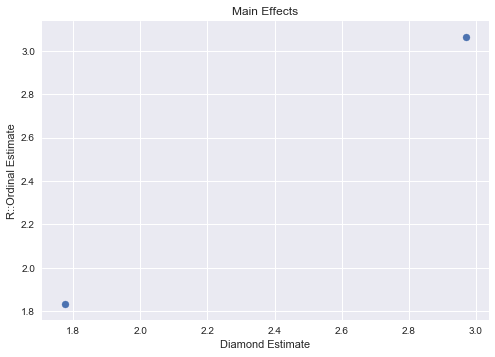

rel difference of 0.030930


In [8]:
plt.scatter(results['main'].main_value * -1.0, fixef_R)
plt.xlabel("Diamond Estimate")
plt.ylabel("R::Ordinal Estimate")
plt.title("Main Effects")
plt.show()
print "rel difference of %f" %(norm(results['main'].main_value*-1.0 - fixef_R, 2)/norm(fixef_R, 2))

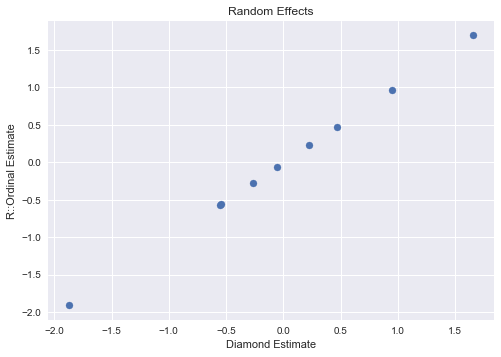

rel difference of 0.022040


In [9]:
plt.scatter(results['judge'].intercept*-1.0, ranef_R)
plt.xlabel("Diamond Estimate")
plt.ylabel("R::Ordinal Estimate")
plt.title("Random Effects")
plt.show()
print "rel difference of %f" %(norm(results['judge'].intercept*-1.0 - ranef_R, 2)/norm(ranef_R, 2))

The two solutions to this convex optimization problem are slightly different; based on the gradients, it appears the diamond solution is slightly closer to the optimum than the R solution.

In [10]:
l2_clogistic_gradient(X=solver.main_design,
                      Y=solver.response,
                      intercept=True,
                      beta=results["main"]["main_value"].values,
                      alpha=results["intercepts"],
                      # need to adjust for random effects
                      offset=solver.grouping_designs["judge"].dot(results["judge"]["intercept"].values))

array([ -2.14328146e-08,  -6.59802346e-08,  -4.57973623e-08,
        -2.35845086e-08,  -8.06506986e-08,  -8.03042726e-08])

In [11]:
l2_clogistic_gradient(X=solver.grouping_designs["judge"],
                      Y=solver.response,
                      intercept=False,
                      beta=results["judge"]["intercept"].values,
                      alpha=results["intercepts"],
                      penalty_matrix=solver.sparse_inv_covs["judge"].sparse_matrix,
                      # adjust for main effects
                      offset=solver.main_design.dot(results["main"]["main_value"].values))

array([ -1.63202785e-13,   3.21132010e-13,   6.21724894e-15,
         5.69197467e-14,   7.99360578e-15,   1.66533454e-16,
        -2.22044605e-16,  -3.15275583e-13,  -1.14908083e-14])

Here's the gradient according to the `R::ordinal` solution

In [12]:
pd.read_csv("gradient_R.csv", header=None).apply(lambda x: np.log10(abs(x)))

,0
0,-5.173180
1,-5.217603
2,-5.801470
3,-5.577097
4,-5.135598
5,-5.365715
6,-4.984617


Since diamond is achieving a smaller gradient, it's closer to the optimal solution. This explains the small discrepancy in the results.